# Performing a Sky Simulation with RFI Sources

This example shows how to include RFI into the simulation. We take an arbitrary sky and use karabo to simulate the visibilities and the interference due to satellites.

In [26]:
import os
from karabo.simulation.observation import Observation
from karabo.simulation.sky_model import SkyModel
from karabo.simulation.telescope import Telescope, VLAVersions
from karabo.simulation.beam import generate_gaussian_beam_data
from karabo.simulation.interferometer import FilterUnits, InterferometerSimulation
from rascil.processing_components import create_visibility_from_ms
from karabo.simulator_backend import SimulatorBackend
from karabo.util.file_handler import FileHandler
from karabo.simulation.signal.rfi_signal import RFISignal
from karabo.simulation.visibility import Visibility

import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
from datetime import datetime, timedelta
from pathlib import Path

from karabo.util.ska_sdp_datamodels.visibility.vis_io_ms import (  # type: ignore[attr-defined] # noqa: E501
    export_visibility_to_ms,
)
from karabo.imaging.imager_rascil import RascilDirtyImager, RascilDirtyImagerConfig
from karabo.imaging.imager_wsclean import WscleanDirtyImager, WscleanDirtyImagerConfig
from ska_sdp_datamodels.image import create_image

import matplotlib.pyplot as plt

%matplotlib inline

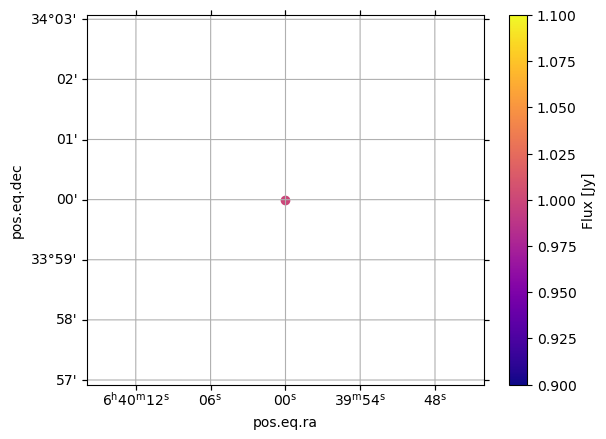

In [2]:
grid_srcs = False
# grid_srcs = True

phasecenter = [100, 34]

# Read in and plot the sky model
# sky = SkyModel.sky_test()
if grid_srcs:
    fov = 4.0
    ras = phasecenter[0] + np.linspace(-fov/2, fov/2, 5)
    decs = phasecenter[1] + np.linspace(-fov/2, fov/2, 5)
    ra_arr, dec_arr = np.meshgrid(ras, decs)
    
    sky = SkyModel()
    sky_data = np.zeros((ra_arr.size, SkyModel.SOURCES_COLS))
    sky_data[:, 0] = ra_arr.flatten()
    sky_data[:, 1] = dec_arr.flatten()
    sky_data[:, 2] = 1
    sky.add_point_sources(sky_data)
else:
    # Sky Model if you want ONE POINT SOURCE ONLY
    sky = SkyModel()
    sky_data = np.array([[*phasecenter, 1]])
    sky.add_point_sources(sky_data)

sky.explore_sky(phase_center=phasecenter, wcs_enabled=True, cfun=lambda x: x, cbar_label="Flux [Jy]")

In [3]:
# Parameter definition
ra_deg = phasecenter[0]
dec_deg = phasecenter[1]
# 2023-02-22 15:45:05
# start_time = datetime(2023, 2, 22, 15, 45, 1)
# 2023-02-22 03:45:05
# start_time = datetime(2023, 2, 22, 3, 45, 1)
# 2023-02-22 04:10:15
# 2023-02-22 04:12:52
start_time = datetime(2023, 2, 22, 4, 12, 51)
# 2023-02-22 04:09:45
# start_time = datetime(2023, 2, 22, 4, 9, 41)
# obs_length = timedelta(hours=0, minutes=60, seconds=0, milliseconds=0)
obs_length = timedelta(hours=0, minutes=0, seconds=40, milliseconds=0)
# start_freq = 5e6 # Starlink far-field
start_freq = 15e6 # Starlink far-field
# start_freq = 45e6 # Starlink near-field
freq_bin = 1.0e6
int_time = 2.0
number_of_time_steps = int(obs_length.total_seconds() / int_time)
number_of_channels = 1

In [4]:
number_of_time_steps

20

In [5]:
# Simulation settings that are the same for OSKAR and RASCIL
observation = Observation(
    phase_centre_ra_deg=ra_deg,
    phase_centre_dec_deg=dec_deg,
    start_date_and_time=start_time,
    length=obs_length,
    number_of_time_steps=number_of_time_steps,
    start_frequency_hz=start_freq,
    frequency_increment_hz=freq_bin,
    number_of_channels=number_of_channels,
)

# observation.compute_hour_angles_of_observation()

In [11]:
# `sim-vis` which is used for the RFI simulation relies on data from SpaceTrack service.
# It needs a login with username and password. Thus, we must provide the login as
# a .yaml file.

credentials_filename = "my_test_credentials.yaml"
# f = open(credentials_filename, "w")
# f.write("username: <add your username>\n")
# f.write("password: <add ypur password>\n")
# f.close()

In [12]:
# The class `RFISignal` controls the simulation of RFI sources
rfi_signal = RFISignal()
rfi_signal.set_credentials_filename(credentials_filename)
# rfi_signal.set

Creating /tmp/karabo-STM-karabo-PvjXQIF7ox/tabsim-files-r1163mj40N for working directory for sim-vis


In [13]:
simulation = InterferometerSimulation(
    channel_bandwidth_hz=1.0e7,
    time_average_sec=8,
    ignore_w_components=False,
    uv_filter_units=FilterUnits.Metres,
    use_gpus=True,
    use_dask=False,
    station_type="Isotropic beam",  # This is only used by OSKAR (beam setting in OSKAR)
)

In [14]:
output_base_directory = Path(
    FileHandler().get_tmp_dir(
        prefix="line-emission-",
        purpose="Example line emission simulation",
    )
)

Creating /tmp/karabo-STM-karabo-PvjXQIF7ox/line-emission-oVFaQquBUI for Example line emission simulation


In [15]:
#### RASCIL SIMULATION
# Load the telescope (SKA-Mid)
telescope = Telescope.constructor("VLA", VLAVersions.D, backend=SimulatorBackend.OSKAR)
# telescope = Telescope.constructor("EDA2", backend=SimulatorBackend.OSKAR)

# telescope.plot_telescope()

rerun = True

if rerun:
    visibility = simulation.run_simulation(
        telescope=telescope,
        sky=sky,
        observation=observation,
        backend=SimulatorBackend.OSKAR,
        primary_beam=None,
        visibility_format="MS",
        visibility_path=os.path.join(output_base_directory, "OSKAR.MS"),
        rfi_signals=rfi_signal
    )
else:
    visibility = Visibility("/tmp/karabo-STM-karabo-PvjXQIF7ox/line-emission-1RAphIC71u/OSKAR.MS")

Matched path /tmp/karabo-STM-karabo-PvjXQIF7ox/line-emission-oVFaQquBUI/OSKAR.MS to format MS
Saved visibility to /tmp/karabo-STM-karabo-PvjXQIF7ox/line-emission-oVFaQquBUI/OSKAR.MS
/home/karabo/.cache/karabo-LTM-karabo-ulUyVcEAYb/tabsim-files-4o4CteTd8v/sim_target_properties.yaml
stdout: 2025-08-22 16:43:03.945017

Theoretical synthesized beam width : 4078 arcsec
Local TLEs loaded  : 1
Remote TLEs loaded : 0
TLEs not found     : 0

Searching which satellites satisfy max_ang_sep: 90 and min_elev: 0
Found 1 matching satellites
NORAD IDs includeed : [46038]
Spectral models for 1 TLE satellites found.

Adding TLE-based satellite RFI sources ...

No gains added ...

Maximum Fringe Frequency is : 0.61 Hz
Maximum RFI Amplitude       : 6.07988 sqrt(Jy)
Maximum sampling rate is    : 4.77 Hz
Recommended n_int is >=     : 10 (11 used)

Telescope Location
------------------
Latitude : 34.07872084786497
Longitude : -107.6183318164056
Elevation : 0.00016802196474896108

Observation Details
--------

In [16]:
visibility_rfi = Visibility(rfi_signal.ms_path)
rfi_signal.ms_path

Matched path /tmp/karabo-STM-karabo-PvjXQIF7ox/tabsim-files-r1163mj40N/vla_obs_27A_020T-0000-0038_011I_001F-1.500e+07-1.500e+07_000PAST_000GAST_000EAST_1SAT_0GRD_1.0e+00RFI/vla_obs_27A_020T-0000-0038_011I_001F-1.500e+07-1.500e+07_000PAST_000GAST_000EAST_1SAT_0GRD_1.0e+00RFI.ms to format MS


'/tmp/karabo-STM-karabo-PvjXQIF7ox/tabsim-files-r1163mj40N/vla_obs_27A_020T-0000-0038_011I_001F-1.500e+07-1.500e+07_000PAST_000GAST_000EAST_1SAT_0GRD_1.0e+00RFI/vla_obs_27A_020T-0000-0038_011I_001F-1.500e+07-1.500e+07_000PAST_000GAST_000EAST_1SAT_0GRD_1.0e+00RFI.ms'

In [17]:
visibility.path

'/tmp/karabo-STM-karabo-PvjXQIF7ox/line-emission-oVFaQquBUI/OSKAR.MS'

In [27]:
# Set Imaging parameters
fov = np.deg2rad(60)
imaging_cellsize = np.deg2rad(telescope.ang_res(start_freq, telescope.max_baseline())/3600)
imaging_npixel = int(fov / imaging_cellsize)
imaging_npixel = imaging_npixel if imaging_npixel % 2 == 0 else imaging_npixel + 1
print(f"Image size of : {imaging_npixel}")

dirty_imager_config = WscleanDirtyImagerConfig(
    imaging_npixel=imaging_npixel,
    imaging_cellsize=imaging_cellsize,
)
wsclean_imager = WscleanDirtyImager(dirty_imager_config)

dirty_imager_config = RascilDirtyImagerConfig(
    imaging_npixel=imaging_npixel,
    imaging_cellsize=imaging_cellsize,
)
rascil_imager = RascilDirtyImager(dirty_imager_config)

Image size of : 126


In [28]:
xyz = (
    rfi_signal.xds.rfi_tle_sat_xyz.data[:, :: rfi_signal.xds.n_int_samples]
    - rfi_signal.xds.ants_xyz.data.mean(axis=1)[None, :: rfi_signal.xds.n_int_samples, :]
)

In [29]:
d_f = 2*telescope.max_baseline()**2/(3e8/start_freq)
R = np.linalg.norm(xyz, axis=-1)[0].compute()

In [30]:
R.mean()/1e3, d_f/1e3

(560.3774502011864, 578.0710050776003)

Creating /tmp/karabo-STM-karabo-PvjXQIF7ox/Imager-Dirty-6TIf4Zt6MU for disk-cache for dirty.fits


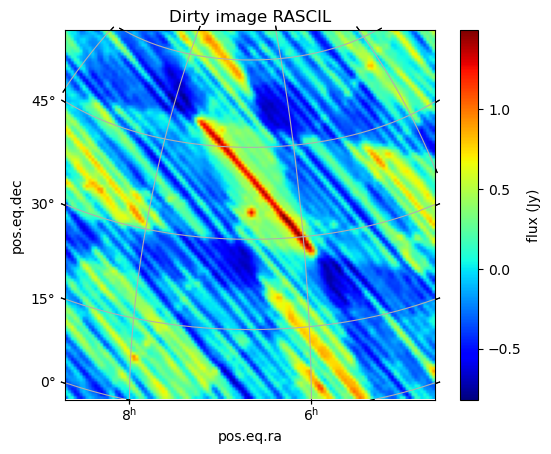

In [31]:
# Imaging with RASCIL
dirty_rascil = rascil_imager.create_dirty_image(visibility)
fig_ras = dirty_rascil.plot(title="Dirty image RASCIL")#, vmin=0, vmax=100.0)

Creating /tmp/karabo-STM-karabo-PvjXQIF7ox/WSClean-dirty-fv2aCfbjGV for Disk cache for WSClean dirty images
WSClean command: cd /tmp/karabo-STM-karabo-PvjXQIF7ox/WSClean-dirty-fv2aCfbjGV && OPENBLAS_NUM_THREADS=1 wsclean -size 126 126 -scale 0.4762790547229444deg /tmp/karabo-STM-karabo-PvjXQIF7ox/line-emission-oVFaQquBUI/OSKAR.MS
WSClean output:
[
WSClean version 3.5 (2024-07-30)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  15-16 (1)
Precalculating weights for uniform weighting...
Opening /tmp/karabo-STM-karabo-PvjXQIF7ox/line-emission-oVFaQquBUI/OSKAR.MS, spw 0 with contiguous MS reader.
Mapping measurement set rows... DONE (0-7020; 7020 rows)
 == Constructing image ==
Detected 23.4 GB of system memory, usage not limited.
Openi

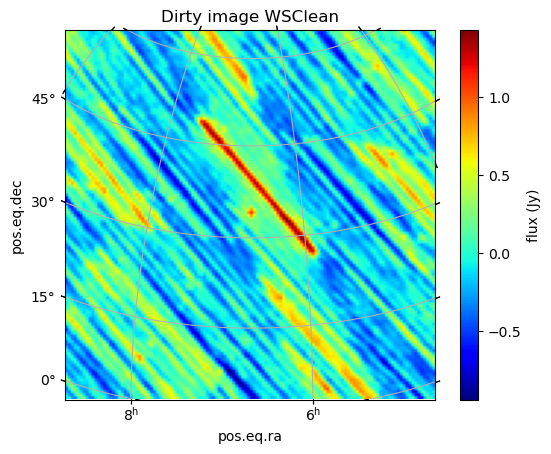

In [32]:
# Imaging with RASCIL
dirty_wsclean = wsclean_imager.create_dirty_image(visibility)
fig_ws = dirty_wsclean.plot(title="Dirty image WSClean")#, vmin=0, vmax=100.0)

In [33]:
radec = rfi_signal.get_satellite_radec()

In [34]:
ax = fig_ras.axes[0]                 # or grab the specific WCSAxes you want
world = ax.get_transform('world')  # 'world' = RA/Dec in the axis' native frame
for i in range(len(radec)):
        ax.plot(radec[i,:,0], radec[i,:,1], 'o', alpha=1, ms=6, mfc='none', mec='black', transform=world) 


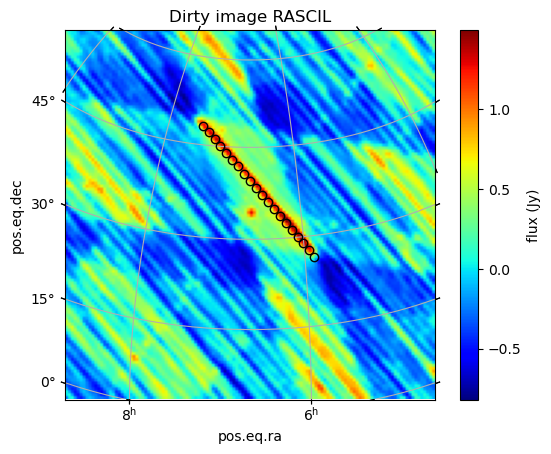

In [35]:
fig_ras